## Метод треугольников на базе метода двойственных усреднений

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import approx_fprime
from numpy.linalg import norm
plt.rcParams['figure.figsize'] = (16, 10)

In [35]:
Y0     = 0
STEP   = 0.15
L = 36

In [54]:
#implementation
def FastDualAveraging(target, x0, eps, set_type = "rn", grad = approx_fprime, step = lambda k: STEP, ALPHA = lambda k : 1/L):
    index = 0
    y_new = Y0
                      
    grad_sum = np.zeros((len(x0),))
    zk = [x0]
    xk = [x0]
    
    while True :
        index += 1
        y_old = y_new
        #x_k+1
        x_new = ALPHA(index)*y_old + (1 - ALPHA(index))*zk[index - 1]
        xk.append(x_new)
        grad_sum += grad(x_new, target, 0.0000001)*step(index)
        #y_k+1 (шаг метода двойственных усреднений зависит от целевого множества)
        if set_type == "rn" :
            y_new = (-1/2*grad_sum)
        elif set_type == "simplex" :
            y_new = (np.exp(-(np.ones(len(x0)) + grad_sum)))
        else :
            print("you oblazhalsya! (rn and simplex are available only)")
            return zk
        #z_k+1
        zk.append(ALPHA(index)*(y_old) + (1 - ALPHA(index))*zk[index - 1])
        #exit condition
        if norm(y_new - y_old, ord = 2) < eps :
            return xk
        


def Gradient(target, x0, eps, set_type = "rn", grad = approx_fprime, step = lambda k: STEP, ALPHA = lambda k: 1/(L)):
    xk = [x0]
    index = 0
    while True:
        index += 1
        xk.append(xk[index - 1] - ALPHA(index)*grad(xk[index - 1], target, 0.0000001))
        if norm(xk[index] - xk[index - 1], ord = 2) < eps / 2 :
            return xk
        

### Исследуем метод на сходимость и характер приближения к решению
Будем рассматривать 2-мерное пространство для удобства визуализации, h пока считаем постоянным.

Для наглядности сравним метод с стандартным методом град. спуска

In [38]:
A = np.array([[1, 2], [2, 3]])
b = np.array([1, 2])
x_expl = np.array([1, 0])
x0_rn = np.array([0.1, 0.2])
x0_smp = np.array([0.1, 0.2])
eps = 0.00005

# ||Ax - b||^2
def func1(x):
    return np.linalg.norm(np.dot(A, x) - b, ord = 2)**2


def gradFunc1(x, func1, eps = 0) :
    return 2*A.transpose() @ (A @ x - b)

#### Построим траекторию сходимости методов для ф-ции ||Ax - b||^2 для Rn
Для симплекса метод не сходится

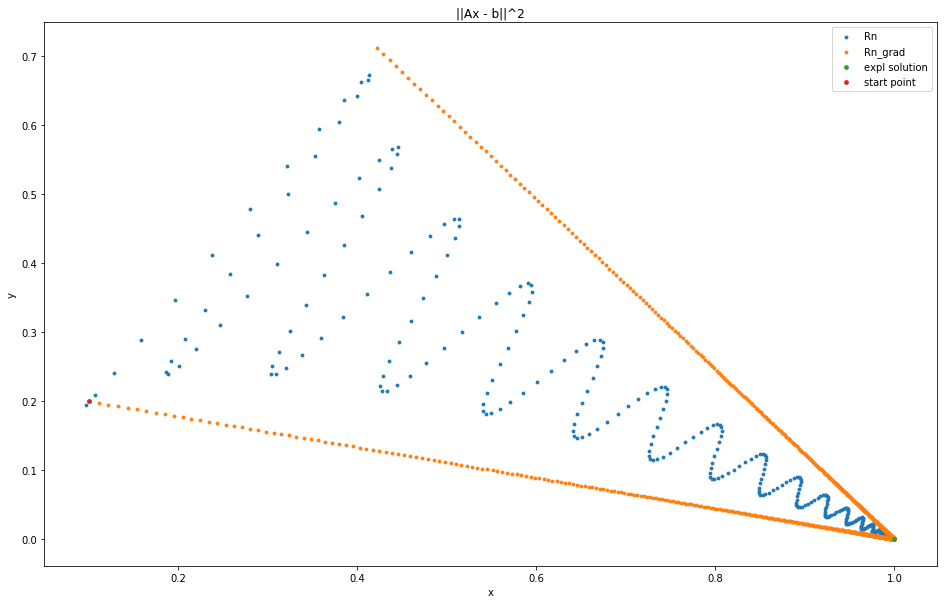

In [64]:
xk_rn   = FastDualAveraging(func1, x0_rn,  eps, set_type = "rn", grad = gradFunc1, ALPHA = lambda k: 1/(L))
xk_grad = Gradient(func1, x0_rn, eps, set_type = "rn", grad = gradFunc1, ALPHA = lambda k: 1/(0.5*L))

plt.scatter([xk_rn[i][0] for i in range(0, len(xk_rn))], [xk_rn[i][1] for i in range(0, len(xk_rn))], label = "Rn", s=8)
plt.scatter([xk_grad[i][0] for i in range(0, len(xk_grad))], [xk_grad[i][1] for i in range(0, len(xk_grad))], label = "Rn_grad", s=8)

plt.scatter(x_expl[0], x_expl[1], label = "expl solution", s = 14)
plt.scatter(x0_rn[0],  x0_rn[1],  label = "start point",   s = 14)

plt.xlabel("x")
plt.ylabel("y")
plt.title("||Ax - b||^2")
plt.legend()

#### Построим график :
$$lnDiff(k) = \ln\left(\frac{f(x_k) - f(x_*)}{f(x_0) - f(x_*)}\right)$$

In [65]:
def ln_diff(x):
    return np.log((func1(x) - func1(x_expl))/(func1(x0_rn) - func1(x_expl)))

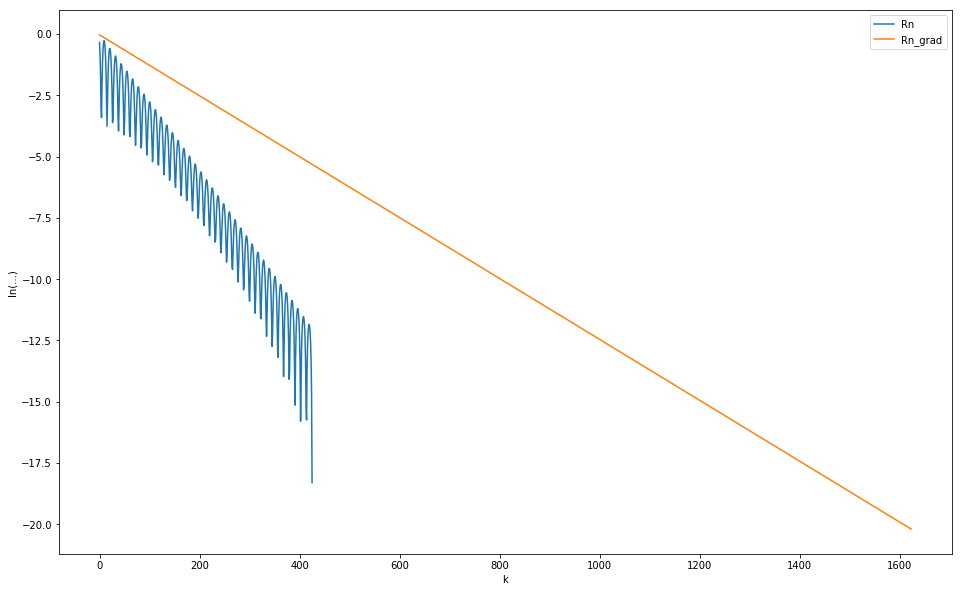

In [66]:
plt.plot([ln_diff(xk_rn[i]) for i in range(3, len(xk_rn))], label = "Rn")
plt.plot([ln_diff(xk_grad[i]) for i in range(3, len(xk_grad))], label = "Rn_grad")
plt.xlabel("k")
plt.ylabel("ln(...)")
plt.legend()

In [58]:
xk_rn[len(xk_rn) - 1]

array([9.99507644e-01, 2.97688734e-04])

In [59]:
xk_grad[len(xk_grad) - 1]

array([0.99316361, 0.00422512])

- Как выбирать Y0, h, L, alpha для наперед заданной функции?
- Как контролировать точность нахождения решения?